In [1]:
####Practica 4 ###
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [2]:
file = "/Users/hillaryram/Downloads/19000-spotify-songs/song_data2.csv"

# Cargamos el conjunto de datos en un dataframe
# Separamos los atributos y el target
all_variables = ['song_name','song_popularity','song_duration_ms','acousticness','danceability','energy','instrumentalness','key','liveness','loudness','audio_mode','speechiness','tempo','time_signature','audio_valence'] #ojo en el tarjet
features = ['song_duration_ms','acousticness','danceability','energy','instrumentalness','key','liveness','loudness','audio_mode','speechiness','tempo','time_signature','audio_valence']
target = ['song_popularity']

df = pd.read_csv(file)
X=df[features]
y=df[target]
df.head()



,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


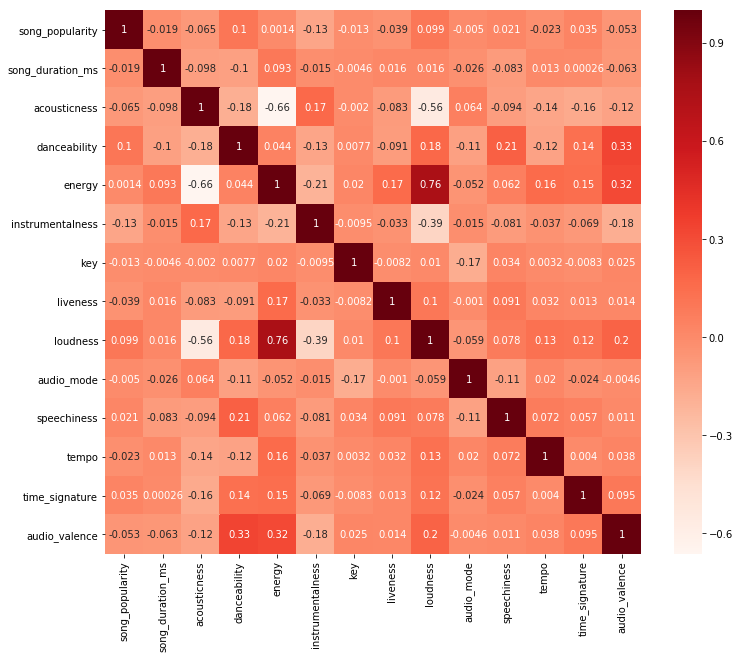

In [3]:
###Filter Method
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [4]:
cor_target = abs(cor["song_popularity"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.1]
relevant_features

song_popularity     1.000000
danceability        0.104290
instrumentalness    0.130907
Name: song_popularity, dtype: float64

In [5]:
#danceability e instrumentalness son las que tienen mayor correlacion
print(df[['danceability','instrumentalness']].corr())

                  danceability  instrumentalness
danceability          1.000000         -0.130483
instrumentalness     -0.130483          1.000000


In [6]:
#Wrapper Method #
X_1 = sm.add_constant(X)
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)



/Users/hillaryram/opt/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


audio_mode           5.057186e-01
speechiness          1.603878e-01
key                  1.532386e-01
song_duration_ms     5.536871e-02
tempo                4.420484e-02
time_signature       7.759963e-03
liveness             6.046582e-05
acousticness         6.051745e-08
energy               5.509363e-17
loudness             7.406474e-24
danceability         1.829117e-26
audio_valence        4.107066e-31
instrumentalness     6.251598e-39
const               6.508524e-111
dtype: float64

In [7]:
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'time_signature', 'audio_valence']


In [8]:
### Recursive Feature Elimination (RFE)
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[False  True  True  True  True False  True False False  True False False
  True]
[7 1 1 1 1 5 1 3 4 1 6 2 1]


/Users/hillaryram/opt/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 12
Desempeño con 12 características: 0.053099


In [10]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index([u'acousticness', u'danceability', u'energy', u'instrumentalness',
       u'liveness', u'loudness', u'audio_mode', u'speechiness',
       u'time_signature', u'audio_valence'],
      dtype='object')


In [11]:
### Embedded Method##
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:1
Desempeño mediante la regularización Lasso: 0.000000


/Users/hillaryram/opt/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hillaryram/opt/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5,1,'Importancia de las caracteristicas usando el modelo de Lasso')

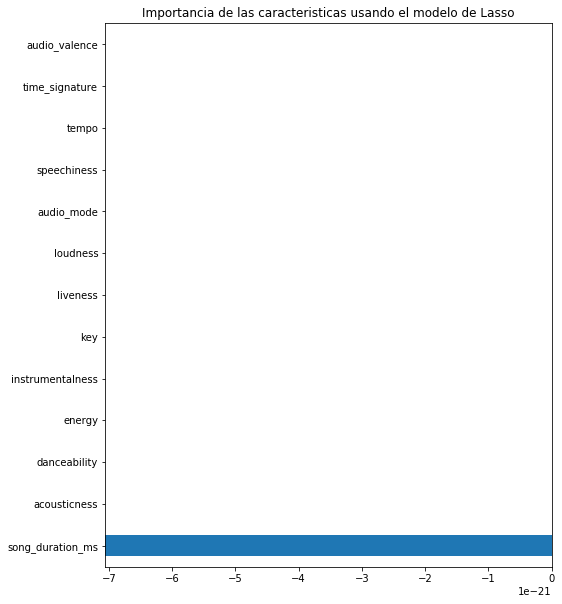

In [14]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las caracteristicas usando el modelo de Lasso")